## Ou-Carter mehod
[J. Chem. Theory Comput. 2018, 14, 5680−5689](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b00717?casa_token=j3Gzwpzmt0oAAAAA:9PQdZFfkeoICbYk_aXhoPGve8cMwNNmnqTCpsHbN2YrBD-mldE2plJ_iKSUod-w1gUBoIvtUXSPgAGib)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True}) # Set save_jk to be True is currently necessary to give Inverter information
                                     # For hartree
psi4.set_memory(int(2.50e10))
psi4.set_num_threads(4)
psi4.core.clean()

import n2v


  Memory set to  23.283 GiB by Python driver.
  Threads set to 4 by Python driver.


First, build the input wavefunction using Psi4.

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "uhf",
                  'DFT_SPHERICAL_POINTS': 350,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                  'CUBIC_BASIS_TOLERANCE': 1e-21, 
                  'DFT_BASIS_TOLERANCE': 1e-21, 
                 })  # Spin-Restricted

wfn = psi4.properties("CCSD/cc-pcvqz", return_wfn=True, molecule=Ne, properties=["dipole"])[1]

ine = n2v.Inverter(wfn)

In [3]:
x = np.linspace(-5,10,1501) + 1e-7
y = [0]
z = [0]
grid, shape = ine.generate_grids(x,y,z)

In [4]:
v = ine.invert("OC", vxc_grid=grid, guide_potential_components=["hartree"], 
               opt_max_iter=35, frac_old=0.9, init="SCAN")

Iter: 1, Density Change: 1.95e-04, Eigenvalue Change: 6.16e+00.
Iter: 2, Density Change: 3.43e-06, Eigenvalue Change: 1.52e-01.
Iter: 3, Density Change: 4.93e-07, Eigenvalue Change: 9.32e-04.
Iter: 4, Density Change: 3.86e-07, Eigenvalue Change: 7.82e-04.
Iter: 5, Density Change: 3.02e-07, Eigenvalue Change: 6.61e-04.
Iter: 6, Density Change: 2.36e-07, Eigenvalue Change: 5.62e-04.
Iter: 7, Density Change: 1.84e-07, Eigenvalue Change: 4.81e-04.
Iter: 8, Density Change: 1.43e-07, Eigenvalue Change: 4.14e-04.
Iter: 9, Density Change: 1.11e-07, Eigenvalue Change: 3.60e-04.
Iter: 10, Density Change: 8.63e-08, Eigenvalue Change: 3.14e-04.
Iter: 11, Density Change: 6.73e-08, Eigenvalue Change: 2.77e-04.
Iter: 12, Density Change: 5.28e-08, Eigenvalue Change: 2.45e-04.
Iter: 13, Density Change: 4.18e-08, Eigenvalue Change: 2.19e-04.
Iter: 14, Density Change: 3.37e-08, Eigenvalue Change: 1.96e-04.
Iter: 15, Density Change: 2.78e-08, Eigenvalue Change: 1.77e-04.
Iter: 16, Density Change: 2.35e-08

Take a look at the effective external potential:

In [5]:
grid_info = ine.grid_to_blocks(grid)
grid_info[-1].set_pointers(wfn.Da(), wfn.Db())

In [6]:
vext = ine.on_grid_esp(grid=grid_info)[0]
vext_eff, vext_eff_beta = ine._get_optimized_external_potential(grid_info=grid_info)[-1]

(-4.0, 4.0)

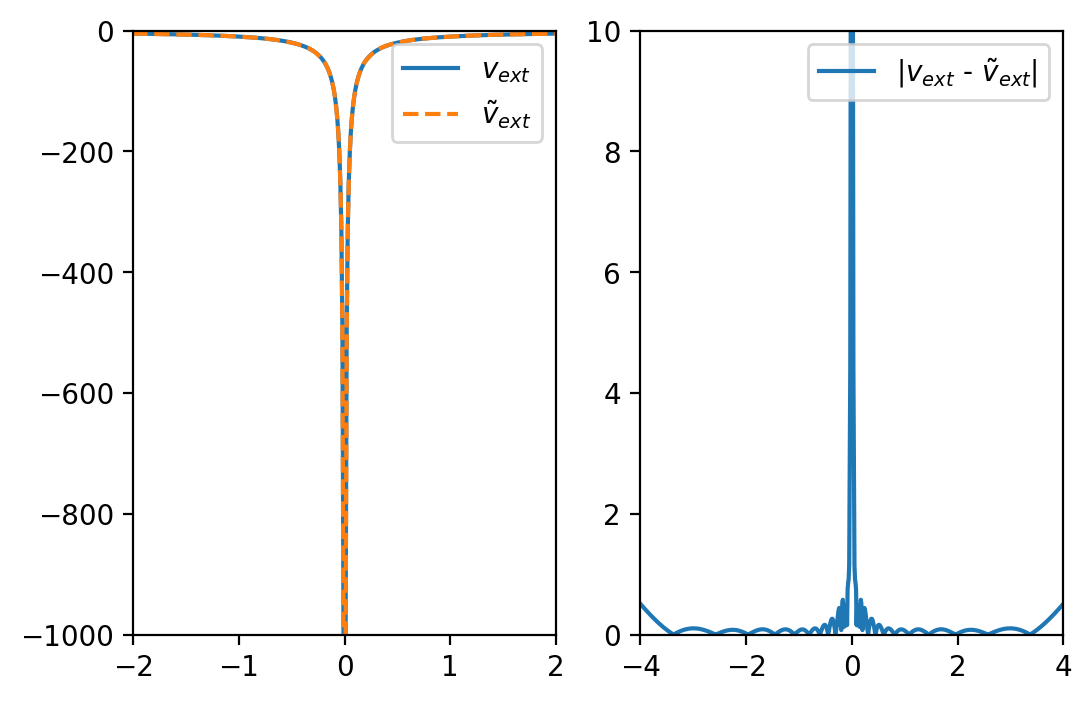

In [7]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].plot(x, vext, label="$v_{ext}$")
ax[0].plot(x, vext_eff, ls="--", label="$\\tilde{v}_{ext}$")
ax[0].legend()
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-1000, 0)

ax[1].plot(x, np.abs(vext-vext_eff), label="$|v_{ext}$ - $\\tilde{v}_{ext}|$")
ax[1].legend()
ax[1].set_ylim(0, 10)
ax[1].set_xlim(-4, 4)

Let's plot things out.

shift (-0.001821046865914222, -0.0018210468659445311)


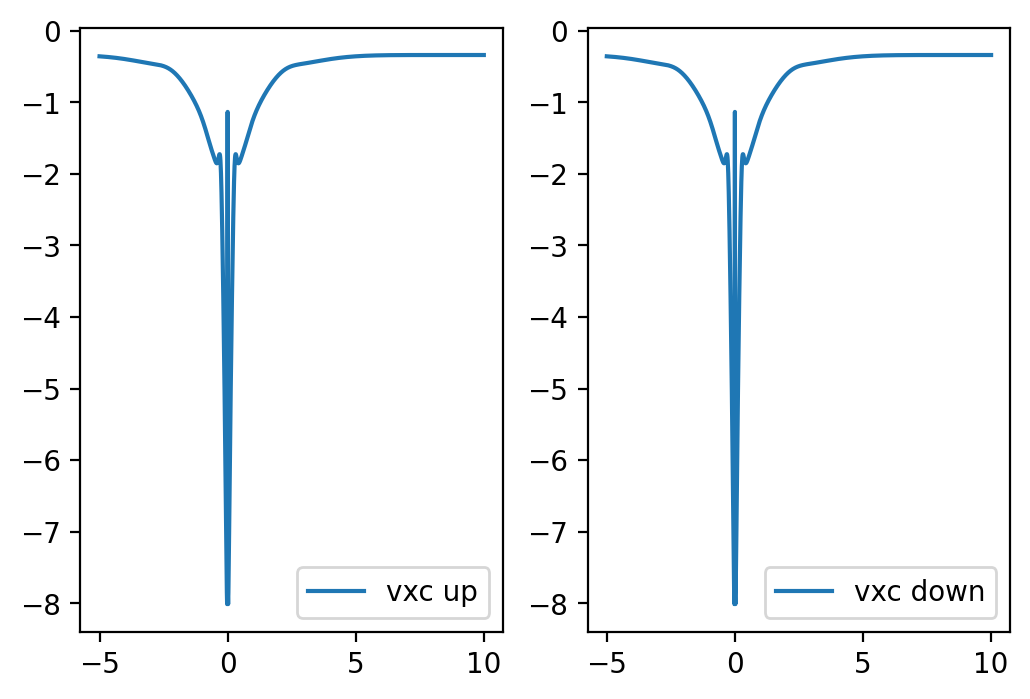

In [8]:
print("shift", v[-1])
fig, ax = plt.subplots(1,2,dpi=200)
# ax[0,0].plot(Ne_xyz, Ne_vxc, label="QMC")
ax[0].plot(x, v[0][0], ls='-', label="vxc up")
ax[1].plot(x, v[0][1], ls='-', label="vxc down")
ax[0].legend()
ax[1].legend()

##### Let's now try a open-shell system: F.

In [9]:
F = psi4.geometry( 
""" 
F
noreorient
nocom
units bohr
symmetry c1
""" )
psi4.set_output_file("temp.psi4")
psi4.core.clean()
psi4.set_options({"reference" : "uhf",
                  'DFT_SPHERICAL_POINTS': 350,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                  'CUBIC_BASIS_TOLERANCE': 1e-21, 
                  'DFT_BASIS_TOLERANCE': 1e-21, 
                  'D_CONVERGENCE': 1e-7,
                  'E_CONVERGENCE': 1e-7,
                 })  # Spin-Restricted

wfn = psi4.properties("CCSD/cc-pcvqz", return_wfn=True, molecule=F, properties=["dipole"])[1]

iF = n2v.Inverter(wfn)

In [10]:
x = np.linspace(-5,10,1501)
y = [0]
z = [0]
grid, shape = iF.generate_grids(x,y,z)

In [11]:
v = iF.invert("OC", vxc_grid=grid, guide_potential_components=["hartree"], 
               opt_max_iter=100, frac_old=0.95, init="SCAN")  # A large frac_old seems to be important
                                                             # to stablize \tau_P

Iter: 1, Density Change: 1.95e-04, Eigenvalue Change: 4.93e+00.
Iter: 2, Density Change: 3.86e-06, Eigenvalue Change: 1.38e-01.
Iter: 3, Density Change: 2.58e-07, Eigenvalue Change: 4.90e-04.
Iter: 4, Density Change: 2.30e-07, Eigenvalue Change: 4.51e-04.
Iter: 5, Density Change: 2.05e-07, Eigenvalue Change: 4.16e-04.
Iter: 6, Density Change: 1.82e-07, Eigenvalue Change: 3.84e-04.
Iter: 7, Density Change: 1.62e-07, Eigenvalue Change: 3.55e-04.
Iter: 8, Density Change: 1.44e-07, Eigenvalue Change: 3.29e-04.
Iter: 9, Density Change: 1.28e-07, Eigenvalue Change: 3.06e-04.
Iter: 10, Density Change: 1.14e-07, Eigenvalue Change: 2.84e-04.
Iter: 11, Density Change: 1.01e-07, Eigenvalue Change: 2.65e-04.
Iter: 12, Density Change: 9.02e-08, Eigenvalue Change: 2.47e-04.
Iter: 13, Density Change: 8.02e-08, Eigenvalue Change: 2.31e-04.
Iter: 14, Density Change: 7.13e-08, Eigenvalue Change: 2.16e-04.
Iter: 15, Density Change: 6.33e-08, Eigenvalue Change: 2.03e-04.
Iter: 16, Density Change: 5.63e-08

In [12]:
grid_info = iF.grid_to_blocks(grid)
grid_info[-1].set_pointers(wfn.Da(), wfn.Db())

In [13]:
wfn_LDA = psi4.energy("SVWN/" + iF.basis_str, molecule=iF.mol, return_wfn=True)[1]

In [15]:
Da_LDA = wfn_LDA.Da().np
Db_LDA = wfn_LDA.Db().np

vxc_LDA = iF.on_grid_vxc(Da=Da_LDA, Db=Db_LDA, grid=grid_info)

(-10.0, 1.0)

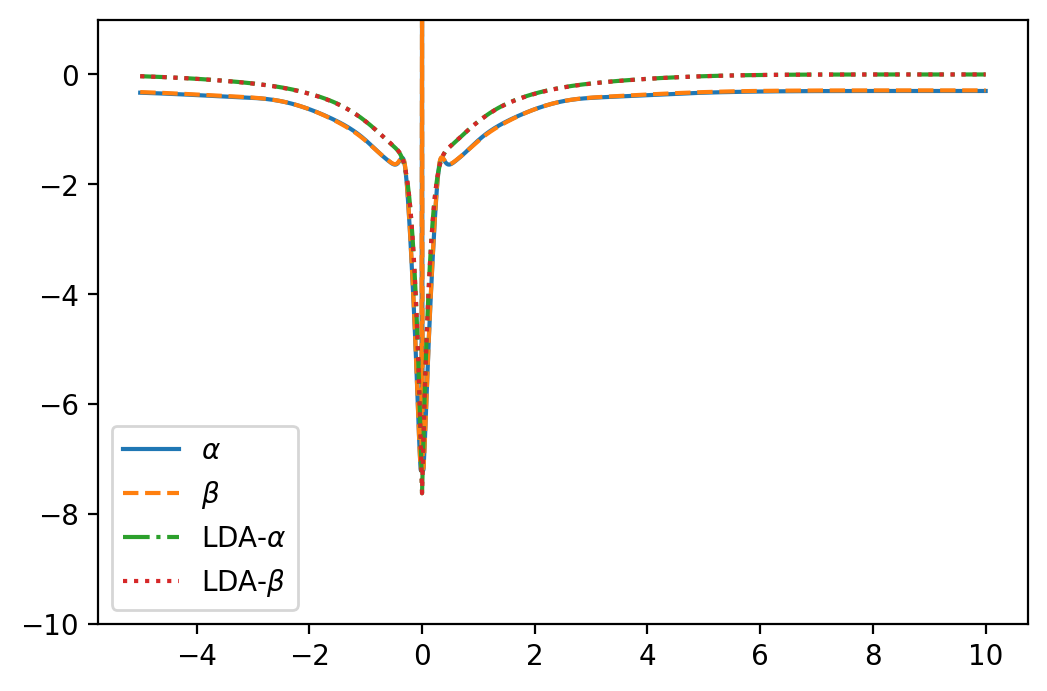

In [16]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x, v[0][0], label="$\\alpha$")
ax.plot(x, v[0][1], ls='--', label="$\\beta$")
ax.plot(x, vxc_LDA[:,0], ls='-.', label="LDA-$\\alpha$")
ax.plot(x, vxc_LDA[:,1], ls=':', label="LDA-$\\beta$")
ax.legend()

ax.set_ylim(-10, 1)